In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Agaronian, Andrei (1017525)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I use 3 hidden layers not to make it to overfit. The number of nodes is sufficiently narrow given the complexity of the task. Only adaptive optimizers were considered since they are expected to work better. Adamax gives the best results. The batch size used is a reasonable tradeoff: trains slow, converge fast. The model doesn't learn after +- 50 epochs, as loss curves flatten. It doesn't over/underfit (length: 405)



Max val score: 80.21%


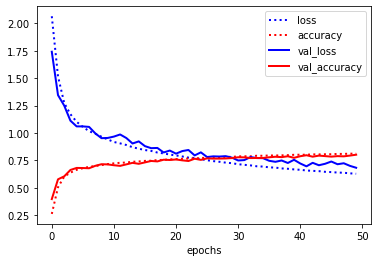

Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_112 (Reshape)        (None, 3072)              0         
_________________________________________________________________
dense_411 (Dense)            (None, 128)               393344    
_________________________________________________________________
dense_412 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_413 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_414 (Dense)            (None, 10)                330       
Total params: 404,010
Trainable params: 404,010
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer="adamax",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



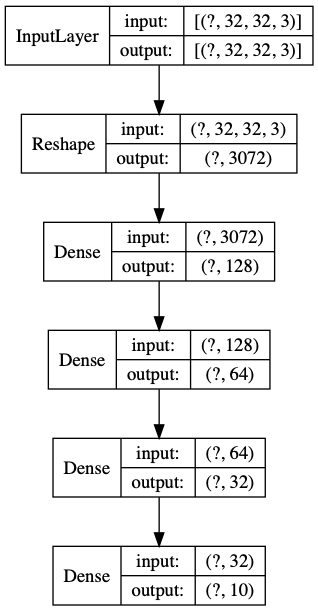

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

task. This decreases the number of parameters for the first dense layer, making the model more simple. Thus, we see that it trains faster. The loss curve for validation set merely progresses after 30 epochs. Yet it doesn't grow, so there is no overfit. Having less redundant information and less parameters to tune, the model achieves better accuracy and lower loss (length: 366)



Max val score: 81.82%


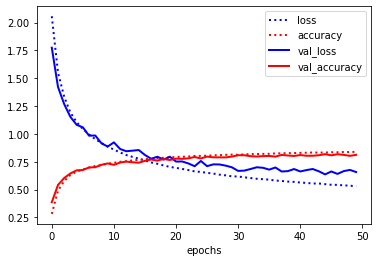

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_113 (Reshape)        (None, 1024)              0         
_________________________________________________________________
dense_415 (Dense)            (None, 128)               131200    
_________________________________________________________________
dense_416 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_417 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_418 (Dense)            (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer="adamax",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

to 0 is a big penalization. Dropout results in slow progress: Adamax already gives different updates for (in)frequent weights, plus it is used for more complex models. Batch Normalization is not good: makes loss go up & down. It is used for very deep networks, this one only has 3 layers. L2 doesn't make model horrible, but since there is no overfit, it makes model underfit. So I stick with model_1_2 (length: 403)



Max val score: 81.82%


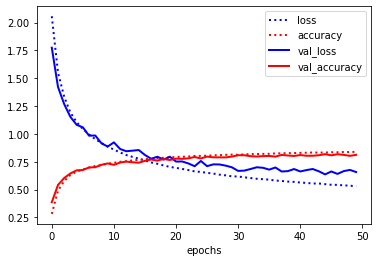

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer="adamax",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I use 3 convolutional layers. The 1st layer has 32 filters: assumed to be sufficiently big not to lose infromation but not too big: in deeper layers I use increasingly more filters due to maxpooling which prevents ovefitting, but reduces the resolution. I increase the number of filters by a factor of 4. This way I try to avoid the decrease in the number of activations. The factor seems big, but it allows to get 2% higher accuracy than using a factor of 2. After flattetning there is dense layer of 64 nodes with the dropout to decrease the observed overfitting (many parameters). The model succeds to generalize while preserving good accuracy and low loss. After 10 epochs expected to start overfitting. (length: 708)



Max val score: 92.26%


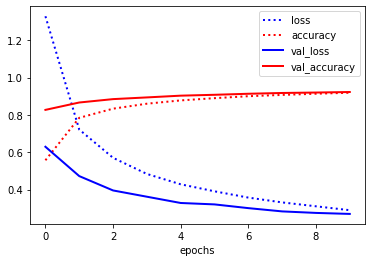

Model: "sequential_190"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_130 (Conv2D)          (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 13, 13, 128)       36992     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 4, 4, 512)         590336    
_________________________________________________________________
flatten_36 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_627 (Dense)            (None, 64)             

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adamax',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



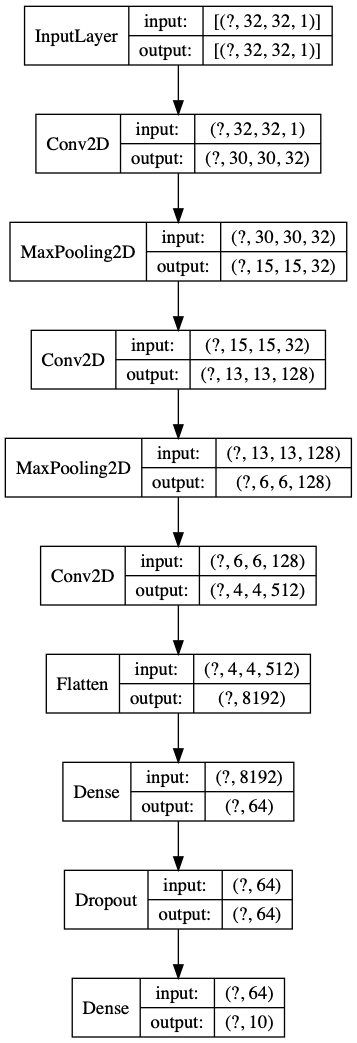

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

does not suit the problem domain. Shearing does not improve performance: most probably since resolution is small, it creates too much noise. Both zooming and rotating improve the performace: make the model ovefit later while achieving greater accuracy. When applied together make the model overfit only after 30th epoch and increase the validiton accuracy by roughly 1.4%. (length: 373)



Max val score: 93.61%


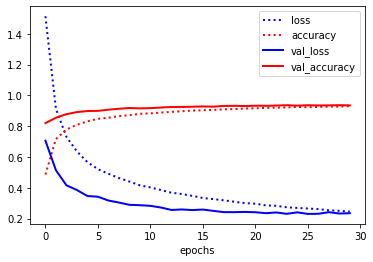


train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    #shear_range=0.2, # the images are of low resolution
    rotation_range=15,
    # width_shift_range=0.2, # digits are assumed to be at the center
    # height_shift_range=0.2, # digits are assumed to be at the center
    # horizontal_flip = true, # makes no sense
    # vertical_flip = true, # makes no sense
)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

be explained since digits within the groups are very similar: first group - diagonal with a cap on top, second group - circular shapes. It seems that the model labels the digit with "1" when it is unsure about its decision. Next, consider the mistakes for the class of digit "1". Model thinks its a 7 when 1 has somewhat perpendicular cap. It thinks its a 4, when cap has very little angle from 1's body. So some errors are introduced due to difference in fonts. Sometimes, pictures are too noisy and even unreadable for human eye. Sometimes, the pictures are mislabeled from the start and model actually gives a correct answer. Sometimes, digit color is barely distinguishable from the background. (length: 699)

Test score: 0.94%


Accuracy:  0.9367005740759392


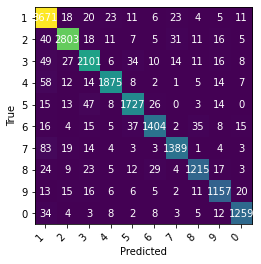

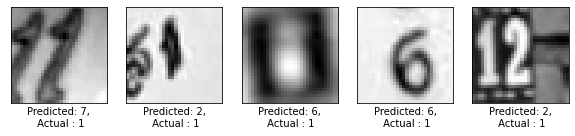

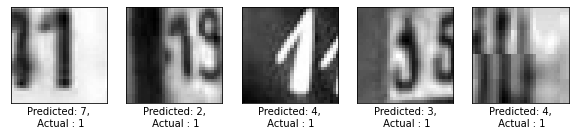

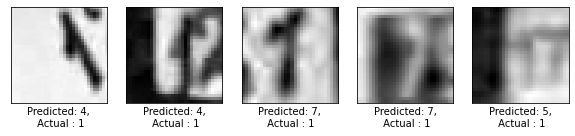

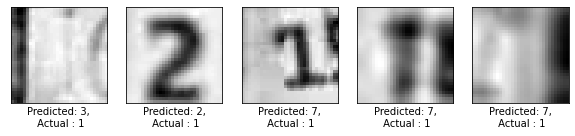

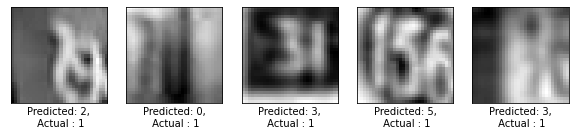

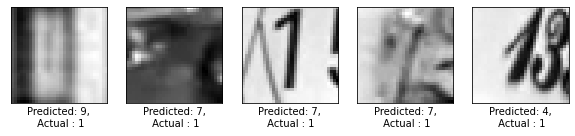

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

are very low resolution and impossible to be intepreted. The model indeed learning something useful. Activations of layer 1: [0,7] - background recogniser; [0,2],[0,3],[1,2] - recognise different edges; Activations of layer 2: [7,14] - recognises the empty circles inside the 8. Nevertheless, some filters are repetetive and some simply don't trigger any patters after being applied to input. (length: 393)



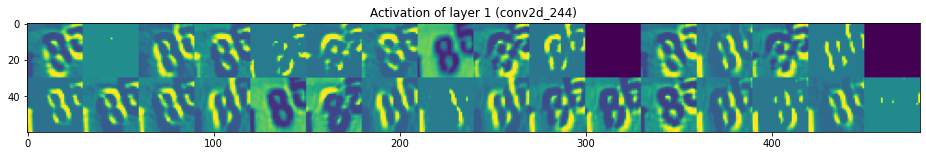

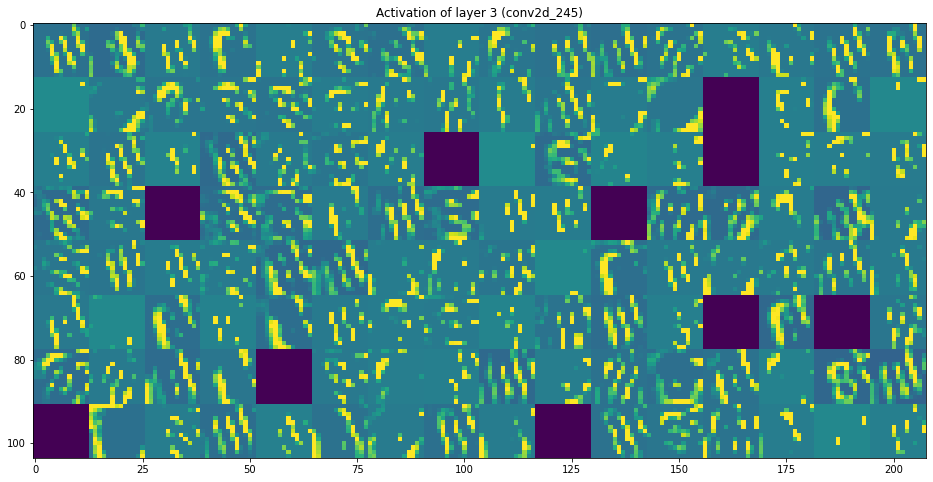

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

Sanity Check
Actual:  8
Predicted: 8
Class activation map


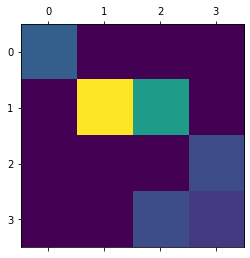

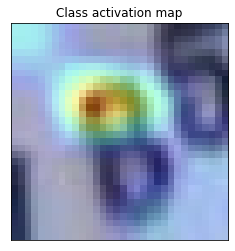

def plot_3_3():
    tf.compat.v1.disable_eager_execution()
    K.clear_session()
    
    x = rgb2gray(X_test)[0]
    x = np.expand_dims(x, axis=0)
    
    # Extract the model from the question 2.2
    model_2_2 = load_model_from_file(base_dir, "model_2_2")
    
    # Sanity check
    preds = model_2_2.predict(x)
    print('Sanity Check')
    print('Actual: ', (np.argmax(y_test[0])+1) % 10)
    print('Predicted:', (np.argmax(preds[0])+1) % 10)
    
    # This is the "8" entry in the prediction vector
    number_output = model_2_2.output[:, 7]
    
    # The is the output feature map of the `conv2d_246` layer,
    # the last convolutional layer in model_2_2
    last_conv_layer = model_2_2.get_layer('conv2d_246')
    
    # This is the gradient of the "9" class with regard to
    # the output feature map of `conv2d_246`
    grads = K.gradients(number_output, last_conv_layer.output)[0]
    
    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradie

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

different domain, the convolution layers may be knowing patterns that are completely irrelevant to our problem. Thus, when we dont unfreeze any layer of 5th block, the model gives poor perfromance. The best choice observed is to unfreeze 5th block entirely. Then, we can observe that model starts to overfit after 2 epochs. So we apply the L2 regurlarization, such that overfit is expected only after 8/9 epochs. (length: 413)



Max val score: 82.96%


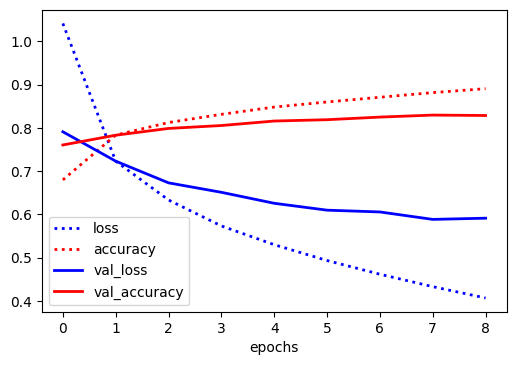

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_27 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_185 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_186 (Dense)            (None, 10)                1290      
Total params: 14,781,642
Trainable params: 7,146,378
Non-trainable params: 7,635,264
_________________________________________________________________
None


def build_model_4_1():
    conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(32, 32, 3))
    model = models.Sequential()
    model.add(conv_base)
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            layer.trainable = True
        elif layer.name == 'block5_conv2':
            layer.trainable = True
        elif layer.name == 'block5_conv3':
            layer.trainable = True
        else:
            layer.trainable = False
    model.add(layers.Flatten())
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adagrad',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



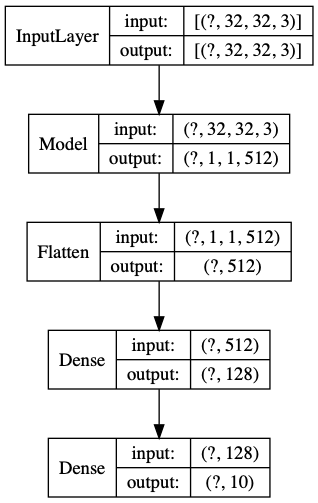

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

regression, random forest, etc. The best match was rbf kernel. Applying scaling does not provide any imporvement. I think we could get a better result, with better embeddings. That is if the convolutional layers would hold only information relevant to the problem domain, while first 4 blocks of VGG16 were trained on completeley different images with much greater resolution. (length: 377)

Pipeline(steps=[('classifier', SVC(random_state=1))])
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    # Extract the model from the question 2.2
    model_4_1 = load_model_from_file(base_dir, "model_4_1")
    # Extract the outputs of the top 5 layers:
    base = model_4_1.layers[0]
    X_train_emb = base.predict(X_train)
    X_test_emb = base.predict(X_test)
    # Store the embeddings
    store_embedding(X_train_emb, "X_train_emb")
    store_embedding(X_test_emb, "X_test_emb")

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' wit

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 56.62 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
